In [16]:
import pandas as pd  
import fbprophet 

In [17]:
fbprophet.__version__

'0.6'

In [15]:
Prophet = fbprophet.Prophet

In [25]:
sales = pd.read_csv('Historical Sales Volume.csv')

In [26]:
sales.head()

,Year,Month,YM,Date,SalesRegion,SKU Code,VolumeHL
0,2016,1,201601,2016/1/2,Heilongjiang,1,2020
1,2016,1,201601,2016/1/2,Heilongjiang,4,79
2,2016,1,201601,2016/1/2,Heilongjiang,9,138
3,2016,1,201601,2016/1/2,Heilongjiang,11,32
4,2016,1,201601,2016/1/2,Heilongjiang,13,95


In [27]:
sales['SKU Code'].value_counts()

31    2212
1     2150
43    2025
27    1972
16    1885
      ... 
57     109
7       96
35      91
6       84
2       35
Name: SKU Code, Length: 69, dtype: int64

In [31]:
sales_JL = sales[sales['SalesRegion']=='Jilin']
sales_HLJ = sales[sales['SalesRegion']=='Heilongjiang']

In [35]:
SKU_JL = sales_JL['SKU Code'].unique()
SKU_HLJ = sales_HLJ['SKU Code'].unique()

In [36]:
DataFrameDict_JL = {elem:pd.DataFrame for elem in SKU_JL}
for key in DataFrameDict_JL.keys():
    DataFrameDict_JL[key]=sales_JL[:][sales_JL['SKU Code']==key]

In [37]:
DataFrameDict_HLJ = {elem:pd.DataFrame for elem in SKU_HLJ}
for key in DataFrameDict_HLJ.keys():
    DataFrameDict_HLJ[key]=sales_HLJ[:][sales_HLJ['SKU Code']==key]

In [40]:
DataFrameDict_HLJ[1] = 

,Year,Month,YM,Date,SalesRegion,SKU Code,VolumeHL
0,2016,1,201601,2016/1/2,Heilongjiang,1,2020
31,2016,1,201601,2016/1/3,Heilongjiang,1,1544
73,2016,1,201601,2016/1/4,Heilongjiang,1,1992
108,2016,1,201601,2016/1/5,Heilongjiang,1,2592
150,2016,1,201601,2016/1/6,Heilongjiang,1,2214
...,...,...,...,...,...,...,...
52719,2019,11,201911,2019/11/24,Heilongjiang,1,285
52756,2019,11,201911,2019/11/25,Heilongjiang,1,613
52794,2019,11,201911,2019/11/26,Heilongjiang,1,890
52935,2019,11,201911,2019/11/29,Heilongjiang,1,613


In [41]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [69]:
def prepare_data(data, YM=201801): 
    
    data_train = data[data['YM']<YM][['Date','VolumeHL']]
    
    data_test = data[data['YM']>=YM][['Date','VolumeHL']]
    
    data_train = data_train.rename({'Date':'ds','VolumeHL':'y'}, axis=1)
    
    data_test = data_test.rename({'Date':'ds','VolumeHL':'y'}, axis=1)
    
    return data_train, data_test

In [71]:
train_data,test_data = prepare_data(DataFrameDict_HLJ[1])

In [72]:
m.fit(train_data)

In [111]:
future = m.make_future_dataframe(periods=120, freq='W')

In [106]:
len(test_data)
len(future)

1211

In [107]:
future.head()

,ds
0,2016-01-02
1,2016-01-03
2,2016-01-04
3,2016-01-05
4,2016-01-06


In [112]:
future.tail()

,ds
775,2020-03-15
776,2020-03-22
777,2020-03-29
778,2020-04-05
779,2020-04-12


In [113]:
forecast = m.predict(future)

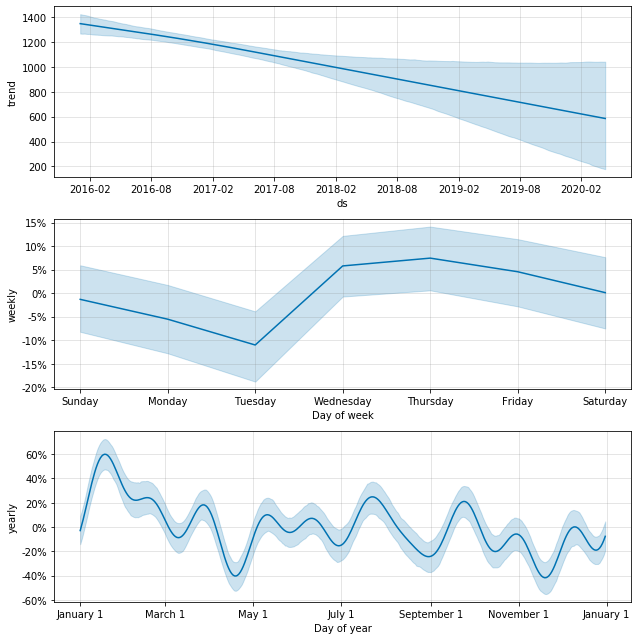

In [114]:
f = m.plot_components(forecast)

In [115]:
def make_verif(forecast, data_train, data_test): 
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [116]:
verif = make_verif(forecast, train_data, test_data)

In [125]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,
2016-01-02,2016-01-02,1347.941288,457.337864,2226.288292,1268.257672,1424.201572,-0.017719,-0.158513,0.115646,0.001059,-0.075087,0.076472,-0.018778,-0.129808,0.098113,0.0,0.0,0.0,1324.056707,2020.0
2016-01-03,2016-01-03,1347.530988,421.799854,2230.400081,1267.997839,1423.430146,0.011570,-0.127555,0.150400,-0.013205,-0.082170,0.059226,0.024775,-0.088848,0.141070,0.0,0.0,0.0,1363.121630,1544.0
2016-01-04,2016-01-04,1347.120689,417.565680,2225.064807,1267.806687,1422.658720,0.016179,-0.110990,0.144673,-0.055368,-0.127889,0.017337,0.071547,-0.041415,0.185894,0.0,0.0,0.0,1368.915734,1992.0
2016-01-05,2016-01-05,1346.710390,507.056046,2266.423986,1267.606443,1422.152997,0.010511,-0.130643,0.140580,-0.110229,-0.188068,-0.038776,0.120740,0.006272,0.234726,0.0,0.0,0.0,1360.865649,2592.0
2016-01-06,2016-01-06,1346.300090,768.033200,2518.574001,1267.406199,1421.899729,0.229324,0.101258,0.369925,0.057836,-0.007302,0.121686,0.171488,0.057979,0.290059,0.0,0.0,0.0,1655.038682,2214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15,2020-03-15,599.453288,-389.341366,1530.212712,200.622153,1041.203704,-0.048639,-0.191380,0.080249,-0.013205,-0.082170,0.059226,-0.035434,-0.151487,0.076294,0.0,0.0,0.0,570.296528,NaN
2020-03-22,2020-03-22,595.863809,-350.063465,1695.768046,194.873756,1041.553457,0.110678,-0.017645,0.239043,-0.013205,-0.082170,0.059226,0.123883,0.010629,0.241338,0.0,0.0,0.0,661.812674,NaN
2020-03-29,2020-03-29,592.274330,-305.722906,1700.809970,187.972958,1042.330151,0.160820,0.016816,0.312036,-0.013205,-0.082170,0.059226,0.174025,0.041529,0.305371,0.0,0.0,0.0,687.523826,NaN


In [118]:
def plot_verif(verif, year=2018):

    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [119]:
from matplotlib import pyplot as plt

ConversionError: Failed to convert value(s) to axis units: '2018'

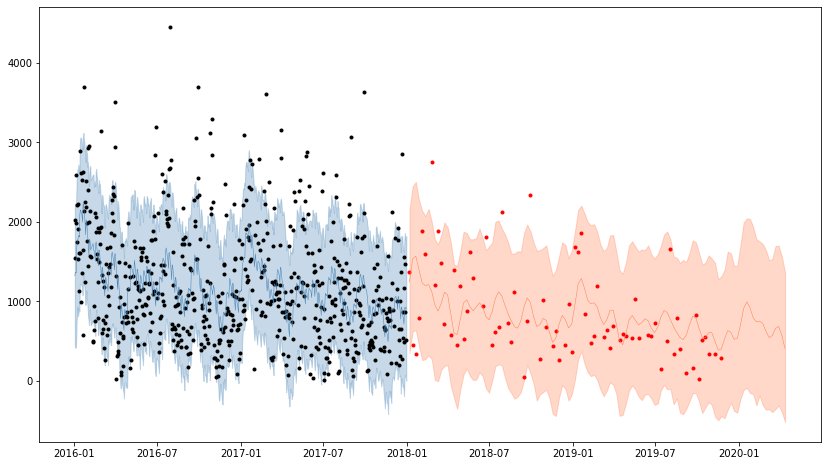

In [120]:
f = plot_verif(verif)

In [121]:
import seaborn as sns 
from sklearn.metrics import mean_absolute_error as MAE 
def plot_joint_plot(verif, x='yhat', y='y', title=None, fpath = '../figures/paper', fname = None): 
    """
    
    Parameters
    ---------- 
    verif : pandas.DataFrame 
    x : string 
        The variable on the x-axis
        Defaults to `yhat`, i.e. the forecast or estimated values.
    y : string 
        The variable on the y-axis
        Defaults to `y`, i.e. the observed values
    title : string 
        The title of the figure, default `None`. 
    
    fpath : string 
        The path to save the figures, default to `../figures/paper`
    fname : string
        The filename for the figure to be saved
        ommits the extension, the figure is saved in png, jpeg and pdf
 
    Returns
    -------
    f : matplotlib Figure object
    """

    g = sns.jointplot(x='yhat', y='y', data = verif, kind="reg", color="0.4")
    
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]

    ax.set_xlim([-5, None])
    ax.set_ylim([-5, 3000])

    #ax.text(100, 2500, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

    ax.set_xlabel("model's estimates", fontsize=15)
    
    ax.set_ylabel("observations", fontsize=15)
    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    
    if fname is not None: 
        for ext in ['png','jpeg','pdf']: 
            g.fig.savefig(os.path.join(fpath, "{}.{}".format(fname, ext)), dpi=200)

NameError: name 'os' is not defined

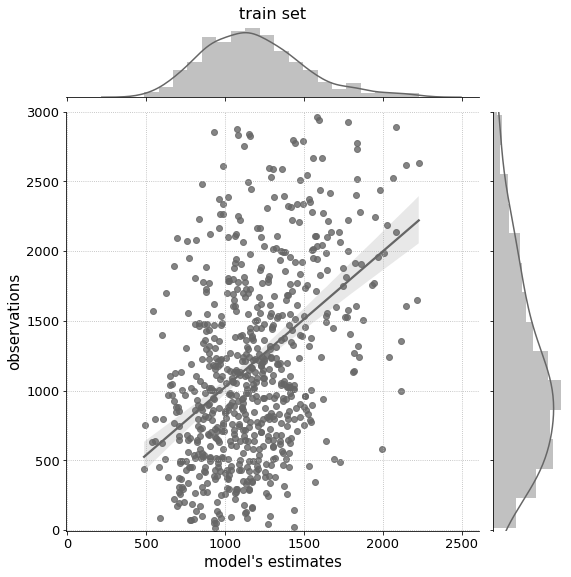

In [122]:
plot_joint_plot(verif.loc[:'2018',:], title='train set', fname='train_set_joint_plot_no_climate')

In [123]:
MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values,verif.loc[:,'y'].values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [97]:
verif.loc[:,'y'].values

array([2020., 1544., 1992., ...,  173.,   nan,   17.])

In [99]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,
2016-01-02,2016-01-02,1347.941288,399.448649,2244.081189,1268.257672,1424.201572,-0.017719,-0.158513,0.115646,0.001059,-0.075087,0.076472,-0.018778,-0.129808,0.098113,0.0,0.0,0.0,1324.056707,2020.0
2016-01-03,2016-01-03,1347.530988,430.388500,2241.282988,1267.997839,1423.430146,0.011570,-0.127555,0.150400,-0.013205,-0.082170,0.059226,0.024775,-0.088848,0.141070,0.0,0.0,0.0,1363.121630,1544.0
2016-01-04,2016-01-04,1347.120689,482.615756,2241.673083,1267.806687,1422.658720,0.016179,-0.110990,0.144673,-0.055368,-0.127889,0.017337,0.071547,-0.041415,0.185894,0.0,0.0,0.0,1368.915734,1992.0
2016-01-05,2016-01-05,1346.710390,470.707850,2241.795436,1267.606443,1422.152997,0.010511,-0.130643,0.140580,-0.110229,-0.188068,-0.038776,0.120740,0.006272,0.234726,0.0,0.0,0.0,1360.865649,2592.0
2016-01-06,2016-01-06,1346.300090,756.308223,2578.732761,1267.406199,1421.899729,0.229324,0.101258,0.369925,0.057836,-0.007302,0.121686,0.171488,0.057979,0.290059,0.0,0.0,0.0,1655.038682,2214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,2019-06-30,732.264018,-350.005101,1492.126434,435.573010,1031.046163,-0.167343,-0.322569,-0.015507,-0.013205,-0.082170,0.059226,-0.154138,-0.283003,-0.020651,0.0,0.0,0.0,609.724773,734.0
2019-07-01,2019-07-01,731.751235,-337.237863,1539.342467,434.501199,1031.066180,-0.206817,-0.355811,-0.058389,-0.055368,-0.127889,0.017337,-0.151448,-0.278152,-0.017059,0.0,0.0,0.0,580.412964,NaN
2019-07-02,2019-07-02,731.238452,-374.661222,1490.552333,433.429387,1031.084053,-0.255353,-0.393621,-0.107255,-0.110229,-0.188068,-0.038776,-0.145124,-0.274741,-0.009693,0.0,0.0,0.0,544.514540,173.0


In [101]:
verif0 = verif.fillna(0)

In [102]:
MAE(verif0['y'],verif0['yhat'],verif0['y'])

623.9930945564673